<a href="https://colab.research.google.com/github/arjunmenonv/EE5180/blob/main/PracticalAssignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
'''
  EE5180 Programming Assignment 1
  Solutions by: Arjun Menon Vadakkeveedu (EE18B104), Electrical Engg. IITM
  9 April 2021
'''

# Import Relevant Modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_short
!pip install pattern  # pattern package required for lemmatizing
from gensim.utils import tokenize, lemmatize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Problem 1: Bayes Classifier

Bayes classifiers fall under the class of **generative classifiers**. Generative classifiers attempt to learn the generation process of a dataset, usually by making some assumptions about the process that generates the data. Then such classifiers use the learned model to make a prediction or classify the unseen data. A simple example is a Naïve Bayes Classifier.

### Naïve Bayes classifier
Consider a dataset $\left\{X^{(i)}, Y^{(i)}\right\}_{i=1}^{m}$. Each $X^{(i)}$ is an $n-$dimensional vector of input features. Let $Y^{(i)} \in \{0,1\}$ denote the class to which $X^{(i)}$ belongs (this can be easily extended to multi-class problems as well). A good classifier has to accurately predict the probability that any given input $X$ falls in class $1$ which is $ P(Y=1 | X)$. 

Recall Bayes theorem,

\begin{align}
P(Y|X) &= \frac{P(X|Y)P(Y)}{P(X)} \\
       &= \frac{P(X_1, X_2, \dots, X_n | Y)P(Y)}{P(X_1, X_2, \dots, X_n)}\\
\end{align}

**We use the assumption that features are independent of each other. That is one particular feature does not affect any other feature. Of course these assumptions of independence are rarely true, which is why the model is referred as the "Naïve Bayes" model. However, in practice, Naïve Bayes models have performed surprisingly well even on complex tasks, where it is clear that the strong independence assumptions are false.**

The independence assumption reduces the conditional probability expression to
\begin{align}
P(Y|X) &= \frac{P(X_1 | Y)P(X_2 | Y) \dots P(X_n | Y)P(Y)}{P(X_1)P(X_2)\dots P(X_n)}\\
\end{align}

The terms $P(X_i|Y)$ and $P(X_i)$ can be easily estimated/learned from the dataset. Hence, the value of $P(Y|X)$ can be found for each value of $Y$. Finally, the class to which $X$ belongs is estimated as $arg\max_{Y}P(Y|X)$. Moreover since $X$ is independent of $Y$, it is only required to find $arg\max_{Y}P(X|Y)P(Y).$ For better understanding with an example refer [this](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c) article.


### Problem statement and Dataset
In this problem, you would implement, train and test a Naïve Bayes model to learn to classify sentiment (positive/negative) of a given text. The training data is in `all_sentiment_shuffled.txt` file.  You can use the function given below to read the dataset


In [36]:
def read_corpus(corpus_file):
    """ This function reads the file in the location specified by string 
    `corpus_file` and returns a list of tuples (list of words in text, label)
    """
    out = []
    with open(corpus_file) as f:
        for line in f:
            tokens = line.strip().split()
            out.append((tokens[3:], tokens[1]))
    return out

In [37]:
corpus = read_corpus('./all_sentiment_shuffled.txt')
print("Example:\n", " Text: ", corpus[0][0], "\n  Label: ", corpus[0][1])
print("Total number of documents =", len(corpus))

Example:
  Text:  ['i', 'bought', 'this', 'album', 'because', 'i', 'loved', 'the', 'title', 'song', '.', 'it', "'s", 'such', 'a', 'great', 'song', ',', 'how', 'bad', 'can', 'the', 'rest', 'of', 'the', 'album', 'be', ',', 'right', '?', 'well', ',', 'the', 'rest', 'of', 'the', 'songs', 'are', 'just', 'filler', 'and', 'are', "n't", 'worth', 'the', 'money', 'i', 'paid', 'for', 'this', '.', 'it', "'s", 'either', 'shameless', 'bubblegum', 'or', 'oversentimentalized', 'depressing', 'tripe', '.', 'kenny', 'chesney', 'is', 'a', 'popular', 'artist', 'and', 'as', 'a', 'result', 'he', 'is', 'in', 'the', 'cookie', 'cutter', 'category', 'of', 'the', 'nashville', 'music', 'scene', '.', 'he', "'s", 'gotta', 'pump', 'out', 'the', 'albums', 'so', 'the', 'record', 'company', 'can', 'keep', 'lining', 'their', 'pockets', 'while', 'the', 'suckers', 'out', 'there', 'keep', 'buying', 'this', 'garbage', 'to', 'perpetuate', 'more', 'garbage', 'coming', 'out', 'of', 'that', 'town', '.', 'i', "'ll", 'get', 'down'

### Preprocessing a text document
We can guess that not all the words in a document will be helpful in classification. The words such as "a", "the", "is", etc appear in all the documents randomly and can be neglected or removed. Also a same word can be written in different tenses while conveying the same mood (example "rot"/"rotten"). Hence the documents need to be preprocessed before using them for training the classifier.

 Libraries such as `gensim`, `nltk` contain functions for doing these preprocessing steps, and you are welcome to use such functions in your code. Formally, these are the preprocessings to be done to the input text to make them simpler and which can improve the performance of your model as well.
* **Tokenization**: 
    1.   Split the text into sentences and the sentences into words
    2.   Lowercase the words and remove punctuation
* Remove all **stopwords** (stopwords are commonly used word such as "the", "a", "an", "in")
* Remove all words that have fewer than 3 characters.
* **Lemmatize** the document (words in third person are changed to first person, and verbs in past and future tenses are changed into present).


In [38]:
""" Implement preprocessing functions here. Use the python modules named above 
for implementing the functions. 
"""
def preprocess(doc):
    """ Function to preprocess a single document
    """
    assert isinstance(doc, str) # assert that input is a document and not the corpus
    processed_doc = strip_punctuation(doc)
    processed_doc = strip_short(remove_stopwords(processed_doc), minsize=3)
    processed_doc = lemmatize(processed_doc)
    return processed_doc
    #return tokenize(processed_doc, lowercase= True)


### Implementation of Naïve Bayes 

You can refer the Naïve Bayes section in [this](https://web.stanford.edu/~jurafsky/slp3/slides/7_NB.pdf) slides (slide #32 has a simple pseudo code) to get a hint about implementation of Naïve Bayes for text classification. Then complete the following functions `train_nb` and `classify_nb`.

NOTE: If you multiply many small probabilities you may run into problems with numeric precision: the probability becomes zero. To handle this problem, it is recommended that you compute the logarithms of the probabilities instead of the probabilities.

In [45]:
def train_nb(documents, labels):
  '''
  Approach: 
  - Preprocess training data and store words (in order of appearance) into arrays pos_vocab and neg_vocab 
  depending on label
  - Convert above arrays to frequency dictionaries with key as word and value as number of occurrences. Using
  this, size of vocabulary for positive and negative reviews can be found (which gives the class prior 
  probability)
  - Compute conditional probability P(word | class) for each word in both classes
  - Returns conditional probability dicts and class prior probabilites
  '''
  # return the data you need to classify new instances
  alpha = 1e-6 # laplace smoothing parameter for NB; if test data contains a word that is not present in 
                 # training data, a large mag negative value (log(P(word|class))) is added to metric in classify fn
  pos_vocab = []
  neg_vocab = []
  for k in range(len(documents)):  
    # training_documents is a subset of corpus documents, which is converted to a string before preprocessing
    # doc[0]: Text; doc[1]: Label
    doc_txt = ' '.join(map(str, documents[k]))
    proc_doc = preprocess(doc_txt)
    if (labels[k] == "pos"):
      for word in proc_doc:
        pos_vocab.append(str(word))
    else:
      for word in proc_doc:
        neg_vocab.append(str(word))
  #pos_dict = {i: pos_vocab.count(i) for i in set(pos_vocab)}
  #neg_dict = {i: neg_vocab.count(i) for i in set(neg_vocab)} 
  #It was found that Counter() is much faster than the above method (commented) at 
  # converting the list to a frequency dictionary
  pos_dict = Counter(pos_vocab)
  neg_dict = Counter(neg_vocab)
  n_pos = sum(pos_dict.values())
  n_neg = sum(neg_dict.values())
  n_vocab = n_pos + n_neg
    #
  condprob_pos = {}
  condprob_neg = {}
  for key, value in pos_dict.items():
    p_wi = (value + alpha)/(n_pos + alpha*n_vocab)
    condprob_pos.update({key: np.log(p_wi)})
  for key, value in neg_dict.items():
    p_wi = (value + alpha)/(n_neg + alpha*n_vocab)
    condprob_neg.update({key: np.log(p_wi)})
  p_pos = np.log(n_pos/n_vocab)
  p_neg = np.log(n_neg/n_vocab)
  return condprob_pos, condprob_neg, p_pos, p_neg     
    # comment the next line out
    # pass

def classify_nb(training_documents, condprob_pos, condprob_neg, p_pos, p_neg):
  '''
  - Inputs: test data documents, conditional probability dicts and prior class probabilites
  - Preprocess test data
  - Compute log(Prob(class | words)) using conditional probability dicts for word given class, and prior class prob
  - Decide class as per MAP rule
  '''
    # return the guess of the classifier
    # input is a subset of corpus[:][0]; i.e. no labels
  predict = []
  for doc in training_documents:
    doc_txt = ' '.join(map(str, doc))
    proc_doc = preprocess(doc_txt)
    pos_metric = p_pos
    neg_metric = p_neg
    for word in proc_doc:
      pos_metric += condprob_pos.get(str(word), 0)    # find value corresponding to key (word) in dict
      neg_metric += condprob_neg.get(str(word), 0)    # if no such key exists, get() returns 0
    if pos_metric > neg_metric:
      predict.append("pos")
    else: predict.append("neg")
  return predict
    # comment the next line out
    #pass

### Train-test split
After reading the dataset, you must split the dataset into training ($80\%$) and test data ($20\%$). Use training data to train the Naïve Bayes classifier and use test data to check the accuracy.

In [46]:
corpus_txt = []
corpus_labels = []
for i in range(len(corpus)):
  corpus_txt.append(corpus[i][0])
  corpus_labels.append(corpus[i][1])
Xtrain, Xtest, ytrain, ytest = train_test_split(corpus_txt, corpus_labels, test_size= 0.2, train_size= 0.8)

In [48]:
condprob_pos, condprob_neg, p_pos, p_neg  = train_nb(Xtrain, ytrain)
# Current Bottleneck is lemmatize() function, which takes close to 1 minute to complete on cpu
predict = classify_nb(Xtest, condprob_pos, condprob_neg, p_pos, p_neg)
correct = 0
incorrect = 0
for i in range(len(predict)):
  if predict[i] == ytest[i]:
    correct += 1
  else: 
    incorrect += 1
print("Accuracy = ", correct/(correct + incorrect))

Accuracy =  0.5606378514477549


## Results
For the corpus dataset, a test accuracy of 0.595 was obtained. This is better than a random guess, although not significatnly better. I believe the following assumptions of the Naive Bayes classifier are problematic here:

$*$ Conditional Independence between words given the class

$*$ The order in which the words appear is not considered in a Naive Bayes model



### Comparison (Bonus)
Also use `sklearn`'s Naïve Bayes classifier and compare its performance with the classifier you implemented. 

Make sure your code is well documented with comments explaining everything done in your algorithm. With this being said, you are free to design your code anyway you like as long as it implements a Naïve Bayes model and is easily understandable. If you digress from the given code template, explain briefly the structure of your code as well.

# Problem 2: Regularization and bias-variance trade-off


### Problem statement
In this question we will see how regularization can be used to prevent overfitting of data and then observe the bias-variance tradeoff in a practical setting.

### Dataset generation
- Generate 10 data points $f(x)=sin(2\pi x)$ where $x \hspace{0.1cm} \epsilon \hspace{0.1cm} [0, 1]$ is sampled uniformly.
- Add Gaussian noise $N(0, 0.5)$ to the generated data. By generating data in this way, we are capturing a property of many real data sets - namely, that they possess an underlying regularity $f(x)$, which we wish to learn, but that individual observations are corrupted by random noise $N(0,0.5)$.
- We will now use this set of 10 data points as the training dataset.

[0.77291785 0.9959812  0.91016974 0.23178682 0.69557976 0.68426988
 0.96428582 0.3325542  0.32659905 0.57690926]


Text(0.5, 1.0, 'Noisy data samples along with sin($2 \\pi x$)')

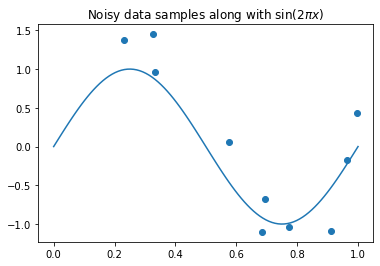

In [49]:
x = np.random.uniform(0, 1, 10)
x_samples = np.linspace(0,1,100)
pi = np.pi
f_x = np.sin(2*pi*x) + 0.5*np.random.randn(10)
plt.scatter(x, f_x)
plt.plot(x_samples, np.sin(2*pi*x_samples))
print(x)
plt.title("Noisy data samples along with sin("r'$2 \pi x$'")")

### Polynomial curve fitting 
- Fit 5 polynomial regression models with varying polynomial orders $M = \{0, 1, 3, 6, 9\}$ on the training dataset. Use the polynomial function of the form:  $y(x, \textbf{w})=\sum^{M}_{j=0}w_jx^j$ and $L2$ loss as the error function: $E(\textbf{w})= \frac{1}{2}\sum^{N}_{n=1}\{y(x_n, \textbf{w}) - t_n)\}^2$, where $t_n$ is the true output for the input $x_n$, and $N$ is the total number of training points.
- For each model: $M = \{0, 1, 3, 6, 9\}$, plot the graph of the function obtained from fitting the model onto the training dataset along with the training dataset points. 
- Report the mean squared error on the training dataset and explain its trend with increasing model complexity. Comment on overfitting and underfitting.
- For each model: $M = \{0, 1, 3, 6, 9\}$, report the coefficients $\textbf{w}^*$. Explain the trend in the coefficients with increasing model complexity. 
- The goal here is to achieve good generalization by making
accurate predictions for new data, and not the training data. Use the data generation procedure used previously to generate 100 data points but with new choices for the random noise values included in the target values. These 100 data points will now form our validation dataset.
- Evaluate each model: $M = \{0, 1, 3, 6, 9\}$ on the validation set and report the mean squared error for each model. 
- Plot the training and validation set mean squared errors for models with $M = \{0, 1, 3, 6, 9\}$ on the same graph. Explain the trend in the error values with increasing model complexity.

Polynomial Fit Coefficients:
Order  0 :  [0.01992687]
Order  1 :  [ 1.6545385  -2.51825318]
Order  3 :  [ -2.16182727  27.45150173 -64.04352145  39.09027576]
Order  6 :  [   34.05309335  -411.00377101  2017.69812887 -4961.40928718
  6467.96291484 -4301.71899815  1155.03902214]
Order  9 :  [-3.02846797e+04  5.39463028e+05 -4.10705269e+06  1.75726512e+07
 -4.66687002e+07  7.99812176e+07 -8.86894103e+07  6.15174191e+07
 -2.42778193e+07  4.16251730e+06]
Training MSE:
Order  0 :  0.9088912599839037
Order  1 :  0.4712422100469379
Order  3 :  0.046450194243165474
Order  6 :  0.029347790776324528
Order  9 :  1.1530234226975967e-16


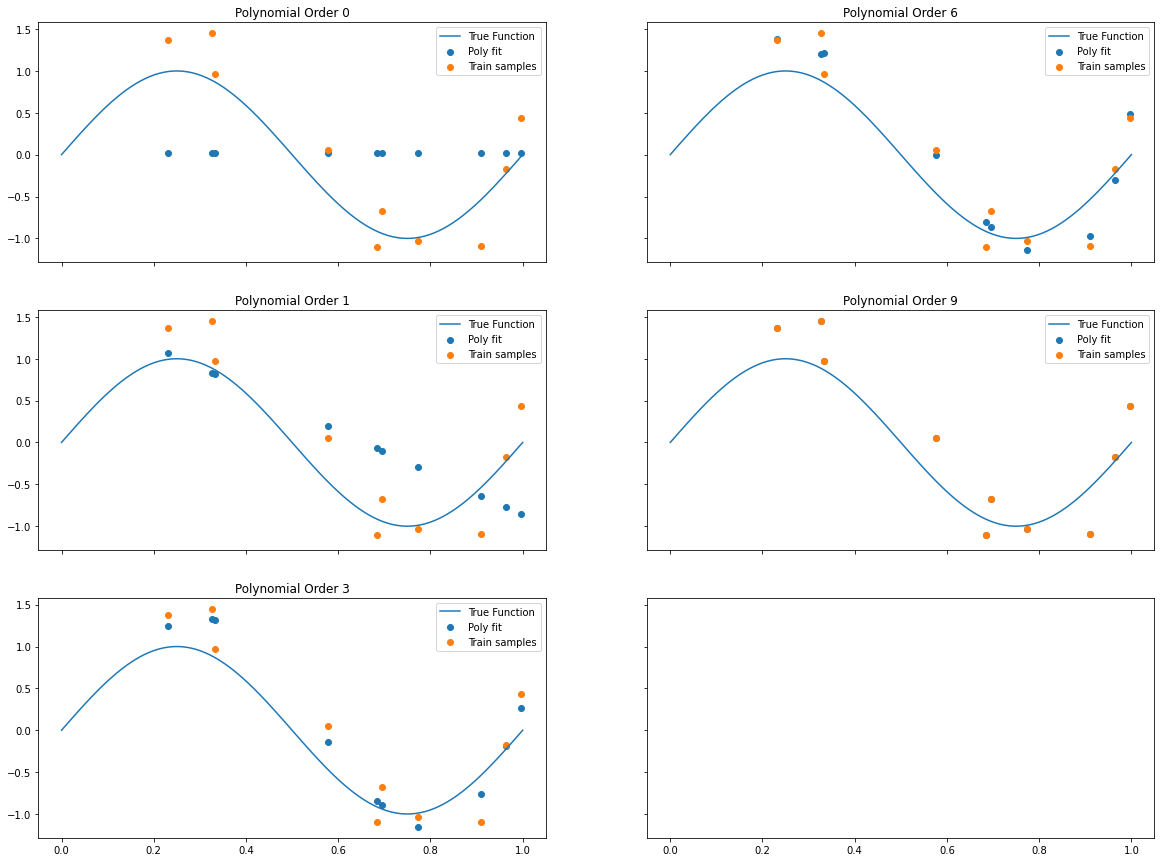

In [52]:
"""
Generate X matrix, compute least squares solution and compute MSE for training data

Least Squares Solution for the linear function X*w = y is
w = pinv(X)*y, where pinv(X) = inv(X.T*X)*X.T
for invertible X, pinv(X) = inv(X)*inv(X.T)*X.T = inv(X)
"""
def gen_X(order, x):
  X = np.zeros((len(x), order+1))
  for i in range(order + 1):
    X[:, i] = np.transpose(np.power(x, i))
  return X

def polyReg(X, y):
  w = np.zeros(X.shape[1])
  w = np.matmul(np.linalg.pinv(X),y)
  return w, np.matmul(X, w.T)

m = np.array([0, 1, 3, 6, 9])
mse_train = np.zeros(len(m))
fit_poly = np.zeros((len(m), len(x)))
fig, ax = plt.subplots(3,2, sharex= True, sharey= True, figsize= (20, 15))
#
x_val = np.random.uniform(0, 1, 100)
f_xval = np.sin(2*pi*x_val) + 0.5*np.random.randn(100)
mse_val = np.zeros(len(m))
fit_polyval = np.zeros((len(m), len(x_val)))

print("Polynomial Fit Coefficients:")
for i in range(len(m)):
  X = gen_X(m[i], x)
  w, fit_poly[i] = polyReg(X, f_x)
  print("Order ", m[i], ": ", w)
  mse_train[i] = np.mean((fit_poly[i] - f_x)**2)
  #
  X_val = gen_X(m[i], x_val)
  fit_polyval[i] = np.matmul(X_val, w.T)
  mse_val[i] = np.mean((fit_polyval[i] - f_xval)**2)

print("Training MSE:")
for i in range(len(m)):
  print("Order ", m[i], ": ", mse_train[i])
for i in range(3):
  for j in range(2):
    if (i + 3*j >= 5): break
    ax[i][j].scatter(x.reshape(-1, 1), fit_poly[i + 3*j])
    ax[i][j].scatter(x, f_x)  
    ax[i][j].plot(x_samples, np.sin(2*pi*x_samples))
    ax[i][j].legend(["True Function", "Poly fit", "Train samples"])
    ax[i][j].title.set_text("Polynomial Order "+ str(m[i+3*j]))

Validation MSE:
Order  0 :  0.8269310343978397
Order  1 :  0.7145381151865924
Order  3 :  0.6203157366973467
Order  6 :  53.831893516241045
Order  9 :  31941946.610730514


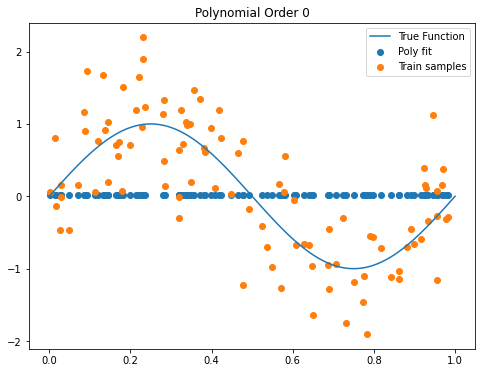

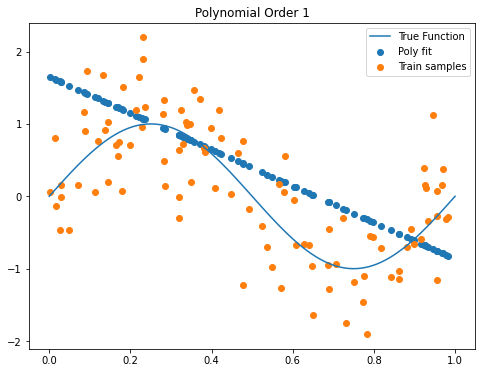

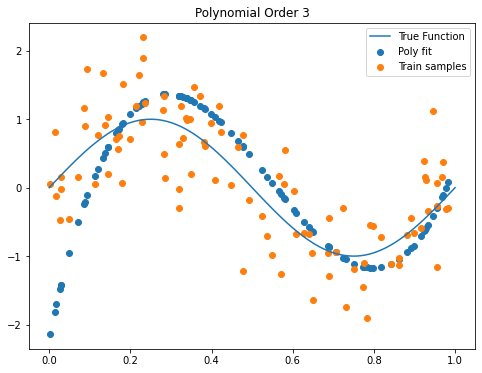

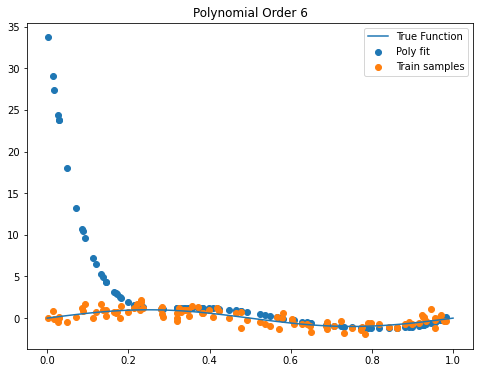

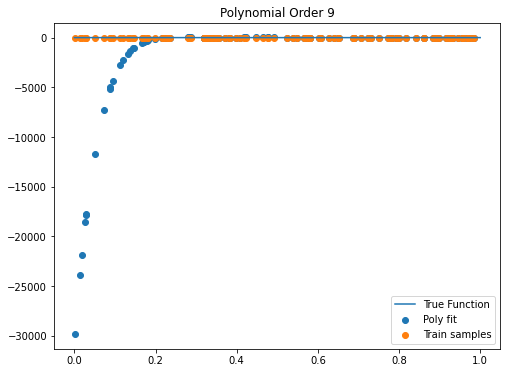

In [53]:
print("Validation MSE:")
for i in range(len(m)):
  print("Order ", m[i], ": ", mse_val[i])
  plt.figure(figsize= (8, 6))
  plt.scatter(x_val.reshape(-1, 1), fit_polyval[i])
  plt.scatter(x_val, f_xval)  
  plt.plot(x_samples, np.sin(2*pi*x_samples))
  plt.legend(["True Function", "Poly fit", "Train samples"])
  plt.title("Polynomial Order "+ str(m[i]))

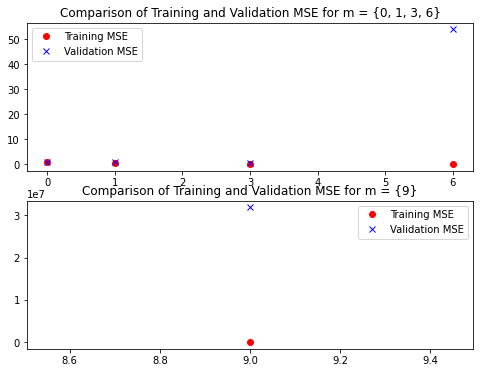

In [55]:
# Plot of training and validation set MSE's
fig, ax = plt.subplots(2, figsize=(8, 6))
ax[0].plot(m[0:-1], mse_train[0:-1], "ro")
ax[0].plot(m[0:-1], mse_val[0:-1], "bx")
ax[0].legend(["Training MSE", "Validation MSE"])
ax[0].title.set_text("Comparison of Training and Validation MSE for m = {0, 1, 3, 6}")
ax[1].plot(m[-1:], mse_train[-1:], "ro")
ax[1].plot(m[-1:], mse_val[-1:], "bx")
ax[1].legend(["Training MSE", "Validation MSE"])
ax[1].title.set_text("Comparison of Training and Validation MSE for m = {9}")


## Inferences on Polynomial Regression

- Given 10 sample points, a polynomial of order 9 can be made to pass through all 10 points. That is, for M = 9, the matrix X is invertible. This explains why the MSE against training data is close to 0 for the 9th order polynomial.

- Notice that the MSE against training data reduces with model complexity. However, this does not guarantee low errors for validation data as the reduction in error in higher order polynomial fits is due to overfitting (9th order is an extreme example of this case).

- Also note that the coefficients for the best fit have large magnitudes for orders 6 and 9. This suggests overfitting- these polynomials could take on values of large magnitude outside the range of training samples (i.e [0, 1])- hence the polynomial does not capture the underlying behaviour of the true function. This is evident from the plots of validation data versus best fits.

- On the other hand, polynomials of order 0 and 1 underfit the model as they do not have enough degrees of freedom to capture the underlying behaviour.

- This issue can be resolved by training the higher order polynomials with regularisation. L2 regularisation penalizes weights of large magnitude which can reduce overfitting.

### Regularization

We've seen the effects of increasing model complexity on the training error and the validation error above. We will now use L2 regularization to reduce overfitting.

- Fit a polynomial regression model of order $M=9$ to the same training dataset as before but now using the regularized error function given by $E^{'}(\textbf{w})= \frac{1}{2}\sum^{N}_{n=1}\{y(x_n, \textbf{w}) - t_n)\}^2 + \frac{\lambda}{2}{\|\textbf{w}\|}^2$ where $\lambda$ is the regularization hyperparameter. Use the following values for $\lambda$: $\lambda={0.01, 0.1, 1}$.
- Report the coefficients of the model fit above for $\lambda={0.01, 0.1, 1}$. Explain the trend in the coefficient values with increasing $\lambda$.
- Find the optimal value of the hyperparameter $\lambda$. 
- Compare the validation error results of the following two models : polynomial regression model of order $M=9$ without regularization and polynomial regression model of order $M=9$ with regularization hyperparameter as estimated above.


Lambda =  0.01
	L2 fit coefficients:  [ 1.97248502 -1.57456686 -2.31073468 -1.82033258 -0.9835798  -0.15148328
  0.56797722  1.15987631  1.63922154  2.02716139]
	Mean Square Training Error:  0.034161505693618456
	Mean Square Validation Error:  0.7471981408445783

Lambda =  0.1
	L2 fit coefficients:  [ 1.70193226 -1.63920636 -1.80579013 -1.22111866 -0.55882335  0.01421379
  0.47508394  0.83788806  1.12272399  1.34744702]
	Mean Square Training Error:  0.0803719472782575
	Mean Square Validation Error:  0.5857657046642636

Lambda =  1.0
	L2 fit coefficients:  [ 0.63108049 -0.54917111 -0.60984515 -0.42224408 -0.21404628 -0.03739866
  0.10231048  0.21069114  0.29465129  0.36006047]
	Mean Square Training Error:  0.4976516027565068
	Mean Square Validation Error:  0.5293731435299172
Optimal lambda =  0.3727593720314942


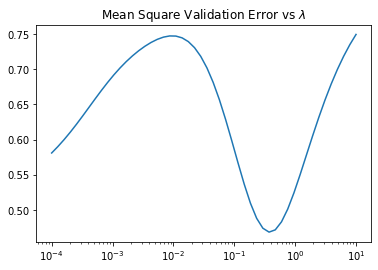

In [56]:
def L2_PolyReg(alpha, X, y):
  alpha_eye = alpha*np.identity(X.shape[1])
  reg_inv = np.linalg.inv(alpha_eye + np.matmul(X.T, X))
  reg_inv = np.matmul(reg_inv, X.T)
  w = np.matmul(reg_inv, y)
  return w, np.matmul(X, w.T)
#
X = gen_X(9, x)
X_val = gen_X(9, x_val)
for alpha in np.array([0.01, 0.1, 1]):
  print("\nLambda = ", alpha)
  w_L2, poly_fitL2 = L2_PolyReg(alpha, X, f_x)
  mse_trainL2 = np.mean((poly_fitL2 - f_x)**2)
  print("\tL2 fit coefficients: ", w_L2)
  print("\tMean Square Training Error: ", mse_trainL2)
  fit_L2val = np.matmul(X_val, w_L2.T)
  mse_valL2 = np.mean((fit_L2val - f_xval)**2)
  print("\tMean Square Validation Error: ", mse_valL2)
# Finding optimal hyperparameter:
lamda = np.logspace(-4, 1, 50)
mse_val = np.zeros_like(lamda)
for alpha in lamda:
  w_L2, poly_fitL2 = L2_PolyReg(alpha, X, f_x)
  fit_L2val = np.matmul(X_val, w_L2.T)
  mse_val[np.where(lamda == alpha)] = np.mean((fit_L2val - f_xval)**2)
plt.figure()
plt.semilogx(lamda, mse_val)
plt.title("Mean Square Validation Error vs "r'$\lambda$')
opt_index = np.argmin(mse_val)
print("Optimal lambda = ", lamda[opt_index])

## Remarks on regularisation

- Magnitude of Weights reduce with increase in L2 regularisation hyperparameter, as expected

- With L2 regularisation, the 9th order polynomial model has similar performance against training and validation data; the validation MSE for polynomial with regularisation is much smaller than that without regularisation

- Optimal value of hyperparameter, $\lambda$ = 0.0568986

### Bias-variance trade-off:

In class you have seen that the expected prediction error for any model can be decomposed as the sum of $bias^2, variance$ and $irreducible\,noise$. We will now observe the bias-variance trade-off for a polynomial regression model of order $M=9$ with varying regularization hyperparameter.
- Generate $50$ datasets, each containing $10$ points, independently, from the curve $f(x)=sin(2\pi x)$. Add gaussian noise $N(0,0.5)$ to each data point.
- Fit a polynomial regression model of order $M=9$ to each training dataset by minimizing the regularized error function $E^{'}(\textbf{w})$ with $\lambda=1$.
- Plot the following:
  - function obtained by training the model on each of the 50 datasets in the same figure.
  - The corresponding average of the 50 fits and the sinusoidal function from which the datasets were generated in the same figure.
- Repeat this exercise for two more $\lambda$ values: $\lambda$ = 0.1, 10.
- Based on the plots obtained, explain the trend in the bias and variance values with increasing model complexity.
- Bonus (optional and will not be graded) : 
  - Plot the $bias^2$, $variance$  and $bias^2 + variance$ against $\lambda$.
  - Also plot the average test error on a test data size of 1000 points (generated in a similiar way as the 50 training datasets, but independently) against $\lambda$ on the same figure.
  - For your reference: 
$$
Bias^2= (E_{D}[\hat f(x)] - f(x))^2
\\
Variance = E_{D}[(\hat f(x) - E_{D}[\hat f(x)])^2]
$$
Here $\hat f$ is the trained model and $D$ is the set of all datasets. Use the $50$ training datasets to compute the empirical estimations.

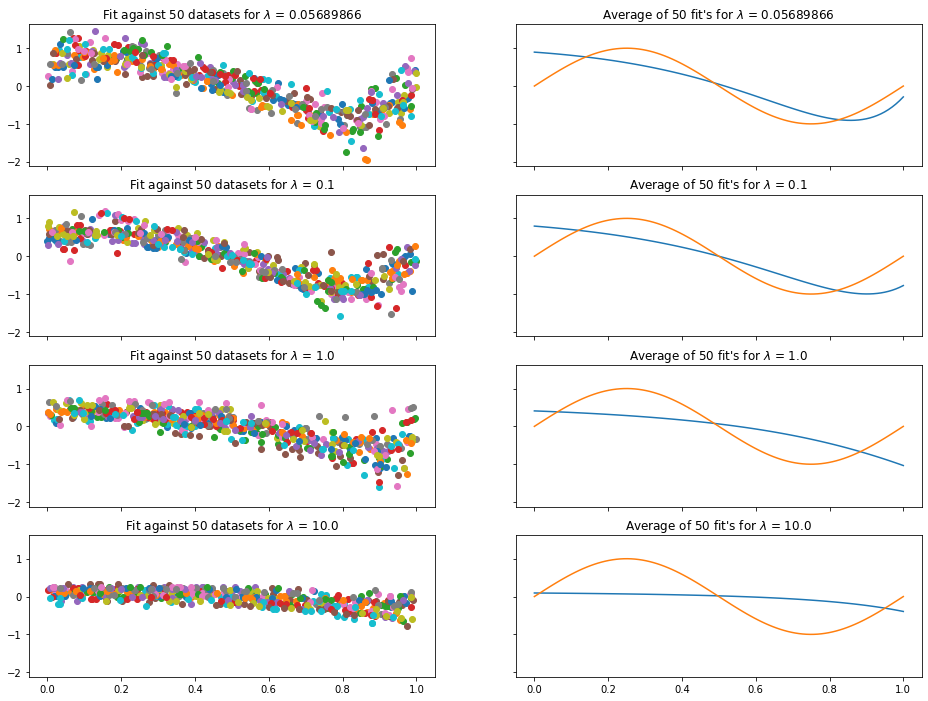

In [57]:
x_dat = np.zeros((50, len(x)))
f_xdat = np.zeros((50, len(x)))
fig, ax = plt.subplots(4,2, sharex=True, sharey= True, figsize= (16, 12))
def fit_and_plot(alpha, row):
  avg_fit = np.zeros(10)
  for i in range(50):
    x_dat[i] = np.random.uniform(0, 1, 10)
    f_xdat[i] = np.sin(2*pi*x_dat[i]) + 0.5*np.random.randn(10)
    X = gen_X(9, x_dat[i])
    w_L2dat, fit_L2dat = L2_PolyReg(alpha, X, f_xdat[i])
    avg_fit += w_L2dat  # average fit obtained as mean of coefficients
    ax[row][0].scatter(x_dat[i], fit_L2dat)
    ax[row][0].title.set_text("Fit against 50 datasets for "r'$\lambda$'" = "+str(alpha))
  avg_fit = avg_fit/50
  X_samples = gen_X(9, x_samples)
  ax[row][1].plot(x_samples, np.matmul(X_samples, avg_fit.T))
  ax[row][1].plot(x_samples, np.sin(2*pi*x_samples))
  ax[row][1].title.set_text("Average of 50 fit's for "r'$\lambda$'" = "+str(alpha))
lamda = np.array([0.05689866, 0.1, 1, 10])
for i in range(len(lamda)):
  fit_and_plot(lamda[i], i)

## Remarks on Bias-Variance Tradeoff

- As is evident from above plots, as $\lambda$ increases, the bias increases, while the variance reduces

- This is so because larger regularisation parameters constrain the models from taking weights of larger magnitudes. This ensures lower variance in the predicted data. In addition, the relatively low magnitudes of weights forces the predictions to have high bias (without regularisation, models assumed weights of large magnitude but achieved close to 0 training MSE)

#Problem 3: Logistic Regression

## Binary Logistic Regression

Logistic regression is a classification algorithm used to assign observations to a discrete set of classes. Unlike linear regression which outputs continuous number values, logistic regression transforms its output using the logistic **sigmoid function** $h_ \theta (\cdot)$ to return a probability value which can then be mapped to two or more discrete classes. $$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{- \theta^Tx} }  $$ 

<br>here, the vector $\theta$ represents the weights and the vector $x$ represents the given inputs.


## Problem 3, Part A: Dataset A



Use Dataset A (``data_prob3_parta.csv``) for this part of the question. The given CSV file has three columns: column 1 is the first input feature, column 2 is the second input feature and column 3 is the output label. Split the dataset into training data (75%) and testing data (25%) randomly.


In [88]:
inp = pd.read_csv("data_prob3_parta.csv", usecols= ["Input feature 1", "Input feature 2", "Output label"]).values
features = inp[:, 0:2]
labels = inp[:, 2]
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size= 0.25, train_size = 0.75)
color_dict = {0: "blue", 1: "green"}

Visualize the training data with a scatter plot (input feature 1 on the X axis, input feature 2 on the Y axis and color the points according to their labels).

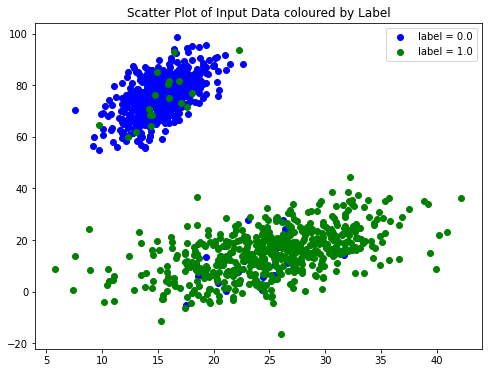

In [89]:
def scatter_data(x, y, color_dict):
  plt.figure(figsize=(8, 6))
  legend_vec = []
  for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(x[ix, 0], x[ix, 1], c= color_dict[g])
    legend_vec.append("label = "+ str(g))
  plt.legend(legend_vec)
  plt.title("Scatter Plot of Input Data coloured by Label")
scatter_data(Xtrain, ytrain, color_dict)

Build the logistic regression model using the training data. 

The scikit library can be used to build the model. Bonus marks will be awarded if the model is built from scratch without using any external libraries. If you are writing your own implementation, try to keep number of features and number of classes as variables for next parts.

Text(0.5, 1.0, 'Decision Boundary on Training Data')

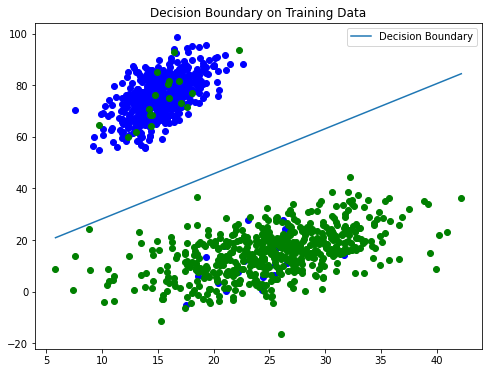

In [118]:
logit = LogisticRegression(random_state=0).fit(Xtrain, ytrain)
scatter_data(Xtrain, ytrain, color_dict)
x0_samples = np.linspace(np.min(Xtrain[:, 0]), np.max(Xtrain[:, 0]), 100)
x1_samples = np.zeros_like(x0_samples)
x1_samples = -(logit.intercept_*np.ones_like(x0_samples) + logit.coef_[0, 0]*x0_samples)/logit.coef_[0, 1]
plt.plot(x0_samples, x1_samples)
plt.legend(["Decision Boundary"])
plt.title("Decision Boundary on Training Data")

Print the final weights.

In [119]:
print("Logistic Model weights:")
print("Intercept: ", logit.intercept_[0])
print("Coeff of Input feature 1: ", logit.coef_[0, 0])
print("Coeff of Input feature 2: ", logit.coef_[0, 1])

Logistic Model weights:
Intercept:  0.9491125191069345
Coeff of Input feature 1:  0.15445294562160522
Coeff of Input feature 2:  -0.08841825921274267


Print the final accuracy on test data.

In [120]:
acc_train = logit.score(Xtrain, ytrain)
acc_test = logit.score(Xtest, ytest)
print("Accuracy on Training Data: ", acc_train)
print("Accuracy on Test Data: ", acc_test)

Accuracy on Training Data:  0.9662222222222222
Accuracy on Test Data:  0.9733333333333334


Plot the scatter plot on test data. On top of this scatter plot, plot the decision boundaries.

Text(0.5, 1.0, 'Decision Boundary on Test Data')

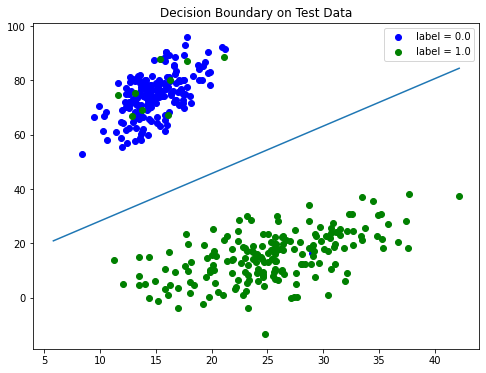

In [121]:
scatter_data(Xtest, ytest, color_dict)
plt.plot(x0_samples, x1_samples)
plt.title("Decision Boundary on Test Data")

## Problem 3, Part B: Dataset B



Use Dataset B (``data_prob3_partb.csv``) for this part of the question. The given CSV file has three columns: column 1 is the first input feature, column 2 is the second input feature and column 3 is the output label. Split the dataset into training data (75%) and testing data (25%) randomly.


In [122]:
inp2 = pd.read_csv("data_prob3_partb.csv", usecols= ["Input feature 1", "Input feature 2", "Output label"]).values
features2 = inp2[:, 0:2]
labels2 = inp2[:, 2]
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(features2, labels2, test_size= 0.25, train_size = 0.75)

Visualize the training data with a scatter plot (input feature 1 on the X axis, input feature 2 on the Y axis and color the points according to their labels).

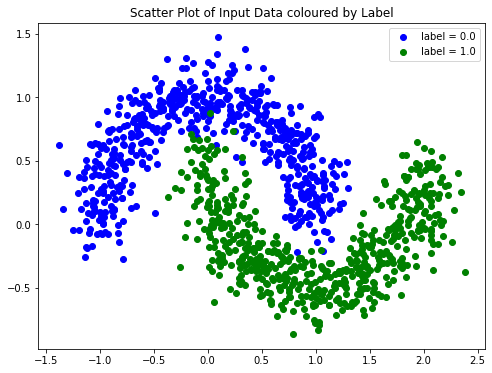

In [123]:
scatter_data(Xtrain2, ytrain2, color_dict)

Build the logistic regression model using the training data. The scikit library can be used to build the model. Bonus marks will be awarded if the model is built from scratch without using any external libraries.

Text(0.5, 1.0, 'Decision Boundary on Training Data')

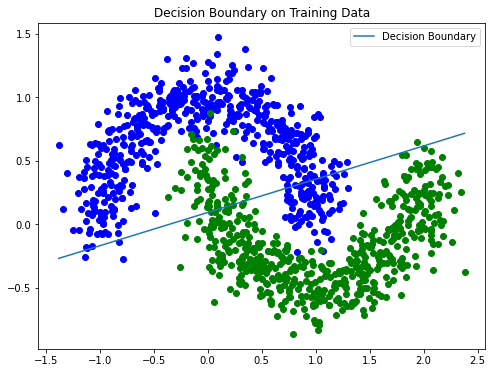

In [124]:
logit2 = LogisticRegression(random_state=0).fit(Xtrain2, ytrain2)
scatter_data(Xtrain2, ytrain2, color_dict)
x0_samples2 = np.linspace(np.min(Xtrain2[:, 0]), np.max(Xtrain2[:, 0]), 100)
x1_samples2 = np.zeros_like(x0_samples2)
x1_samples2 = -(logit2.intercept_*np.ones_like(x0_samples2) + logit2.coef_[0, 0]*x0_samples2)/logit2.coef_[0, 1]
plt.plot(x0_samples2, x1_samples2)
plt.legend(["Decision Boundary"])
plt.title("Decision Boundary on Training Data")

Print the final weights.

In [125]:
print("Logistic Model weights:")
print("Intercept: ", logit2.intercept_[0])
print("Coeff of Input feature 1: ", logit2.coef_[0, 0])
print("Coeff of Input feature 2: ", logit2.coef_[0, 1])

Logistic Model weights:
Intercept:  0.4221305539184419
Coeff of Input feature 1:  1.213737096757541
Coeff of Input feature 2:  -4.630658092147085


Print the final accuracy on test data.

In [126]:
acc_train = logit2.score(Xtrain2, ytrain2)
acc_test = logit2.score(Xtest2, ytest2)
print("Accuracy on Training Data: ", acc_train)
print("Accuracy on Test Data: ", acc_test)

Accuracy on Training Data:  0.8746666666666667
Accuracy on Test Data:  0.88


Plot the scatter plot on test data. On top of this scatter plot, plot the decision boundaries.

Text(0.5, 1.0, 'Decision Boundary on Test Data')

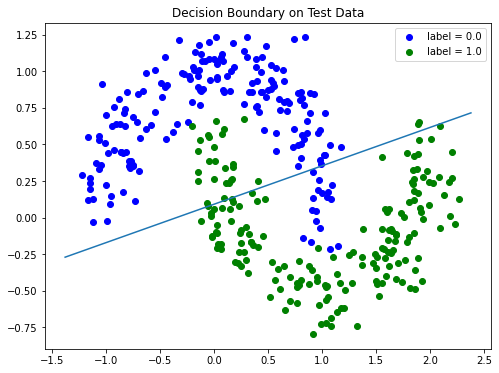

In [127]:
scatter_data(Xtest2, ytest2, color_dict)
plt.plot(x0_samples2, x1_samples2)
plt.title("Decision Boundary on Test Data")

As you can see, a straight line is not the best decision boundary for this type of data. In the next part, we will try polynomial feature mapping to generate more features and build the classifier on top of it.

## Problem 3, Part C: Polynomial Feature Mapping



Use Dataset B (``data_prob3_partb.csv``) for this part of the question.


Generate more features for each datapoint using the following transformation.

For a datapoint $(x_1, x_2)$,
$$ (x_1, x_2) \rightarrow (x_1, x_2, x_1^2, x_2^2, x_1^3, x_2^3, ..., x_1^T, x_2^T) $$
Now, instead of giving $(x_1, x_2)$ as the input to the classifier, use the transformed data as the input to the classifier.

Generate the transformed training and testing dataset using Dataset B (``data_prob3_partb.csv``).

In [128]:
t = 3
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(features2, labels2, test_size= 0.25, train_size = 0.75)
# Xtrain2 and Xtest2 are transformed to a polynomial feature space
def feature_map(feature, order):
  poly_feat = np.zeros((feature.shape[0], feature.shape[1]*order))
  for i in range(order):
    poly_feat[:, feature.shape[1]*i:feature.shape[1]*(i+1)] = np.power(feature, i+1)
  return poly_feat
poly_Xtrain2 = feature_map(Xtrain2, t)
poly_Xtest2 = feature_map(Xtest2, t)

Build the logistic regression model using the transformed training data. The scikit library can be used to build the model. Bonus marks will be awarded if the model is built from scratch without using any external libraries.

In [129]:
logit2_poly = LogisticRegression(random_state=0).fit(poly_Xtrain2, ytrain2)
acc_train = logit2_poly.score(poly_Xtrain2, ytrain2)
acc_test = logit2_poly.score(poly_Xtest2, ytest2)
print("Accuracy on Training Data: ", acc_train)
print("Accuracy on Test Data: ", acc_test)

Accuracy on Training Data:  0.9724444444444444
Accuracy on Test Data:  0.9786666666666667


Try different values of $T$ (highest number of degree) between 3 to 10. Find out which value of $T$ gives the best test accuracy. Please print that values of $T$ in the below cell.

In [130]:
t_values = np.linspace(3, 10, 8, dtype= int)
test_accuracy = np.zeros(t_values.shape)
for i in range(len(t_values)):
  poly_Xtrain2 = feature_map(Xtrain2, t_values[i])
  poly_Xtest2 = feature_map(Xtest2, t_values[i])
  logit2_poly = LogisticRegression(random_state=0).fit(poly_Xtrain2, ytrain2)
  test_accuracy[i] = logit2_poly.score(poly_Xtest2, ytest2)
ix_opt = np.argmax(test_accuracy)
ix_opts = np.where(test_accuracy == test_accuracy[ix_opt])
print("Test Accuracy: ", test_accuracy)
print("Optimal values of T: ", t_values[ix_opts])

Test Accuracy:  [0.97866667 0.97866667 0.98133333 0.98666667 0.98666667 0.98666667
 0.984      0.984     ]
Optimal values of T:  [6 7 8]


Print the final weights.

In [131]:
poly_Xtrain2 = feature_map(Xtrain2, t_values[ix_opt])
poly_Xtest2 = feature_map(Xtest2, t_values[ix_opt])
logit2_poly = LogisticRegression(random_state=0).fit(poly_Xtrain2, ytrain2)
print("Coefficients of Model: ", logit2_poly.intercept_, logit2_poly.coef_)

Coefficients of Model:  [3.79923985] [[ 0.09253741 -5.52484822 -6.18733029  0.60498068  0.19896888 -1.80869002
  -2.20393563 -0.62041552  1.89829518 -1.1073482   1.2577735  -0.72214242]]


Print the final accuracy on transformed test data.

In [132]:
acc_test = logit2_poly.score(poly_Xtest2, ytest2)
print("Accuracy of model: ", acc_test)

Accuracy of model:  0.9866666666666667


Plot the scatter plot on test data (note that this is  the original data , not the transformed one). On top of this scatter plot, plot the new decision boundaries.

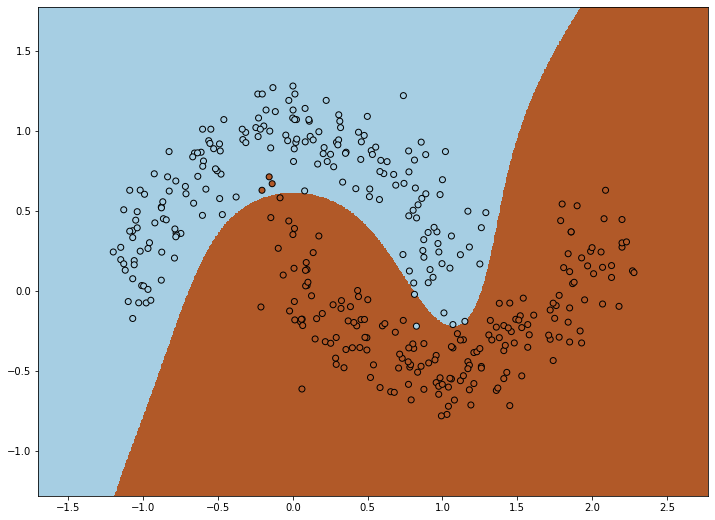

In [133]:
x_min, x_max = Xtest2[:, 0].min() - .5, Xtest2[:, 0].max() + .5
y_min, y_max = Xtest2[:, 1].min() - .5, Xtest2[:, 1].max() + .5
h = 5e-3  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xsamples = np.c_[xx.ravel(), yy.ravel()]
Z = logit2_poly.predict(feature_map(Xsamples,t_values[ix_opt]))
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize= (12, 9))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
#
plt.scatter(Xtest2[:, 0], Xtest2[:, 1], c=ytest2, edgecolors='k', cmap=plt.cm.Paired)

## Problem 3, Part D: Multi-class Logistic Regression

## Multi-class Logistic Regression

In case of a multi-class classification problem (when the number of classes is greater than two), a **softmax function** is used instead. 
$$\text{Softmax}(\theta_{i}) = \frac{\exp(\theta_i)}{\sum_{j=1}^{N} \exp(\theta_j)}$$ where $j$ varies from $1$ to $N$ which is the number of classes and  $\theta_{i}$ is $$\theta_{i}=W_{i}*x^{(i)}+b$$ Where $x^{(i)}$ is a feature  vector of dimensions $D \times 1$ and $W_{i}$ is the $i$-th row of the weight matrix $ W$ of  dimensions $N \times D$  and $b$ is the bias having dimensions $D \times 1$.


Use Dataset D (``data_prob3_partd.csv``) for this part of the question. The given CSV file has three columns: column 1 is the first input feature, column 2 is the second input feature and column 3 is the output label. Split the dataset into training data (75%) and testing data (25%) randomly.


In [134]:
inp3 = pd.read_csv("data_prob3_partd.csv", usecols= ["Input feature 1", "Input feature 2", "Output label"]).values
features3 = inp3[:, 0:2]
labels3 = inp3[:, 2]
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(features3, labels3, test_size= 0.25, train_size = 0.75)
color_dict_multi = {0: "blue", 1: "green", 2: "red"}

Visualize the training data with a scatter plot (input feature 1 on the X axis, input feature 2 on the Y axis and color the points according to their labels).

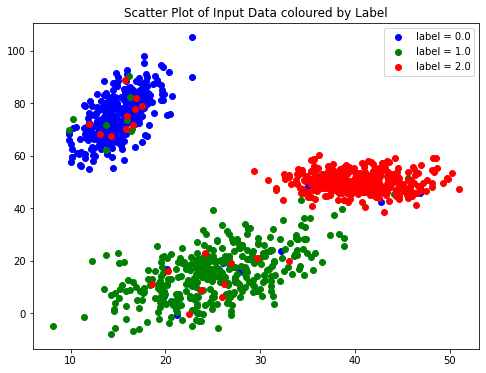

In [135]:
scatter_data(Xtrain3, ytrain3, color_dict_multi)

Build the logistic regression model using the training data. The scikit library can be used to build the model. Bonus marks will be awarded if the model is built from scratch without using any external libraries.

In [136]:
logit3 = LogisticRegression(random_state= 0, multi_class= "multinomial").fit(Xtrain3, ytrain3)

Print the final weights.

In [137]:
print("Coefficients of Model: ", logit3.intercept_, logit3.coef_)

Coefficients of Model:  [ 1.226485    5.03445298 -6.26093797] [[-0.12284338  0.04190813]
 [-0.04454386 -0.07967675]
 [ 0.16738724  0.03776862]]


Print the final accuracy on test data.

In [138]:
acc_test = logit3.score(Xtest3, ytest3)
print("Accuracy of model: ", acc_test)

Accuracy of model:  0.9546666666666667


Plot the scatter plot on test data. On top of this scatter plot, plot the decision boundaries.

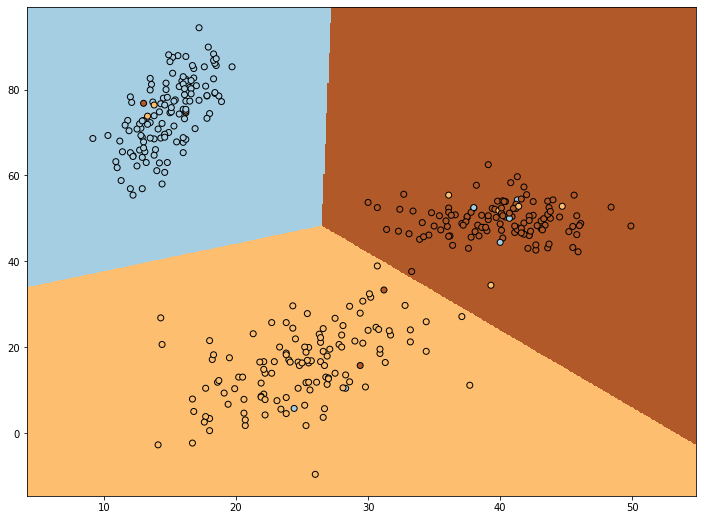

In [139]:
x_min, x_max = Xtest3[:, 0].min() - 5, Xtest3[:, 0].max() + 5
y_min, y_max = Xtest3[:, 1].min() - 5, Xtest3[:, 1].max() + 5
h = 0.1  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xsamples = np.c_[xx.ravel(), yy.ravel()]
Z = logit3.predict(Xsamples)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize= (12, 9))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
#
plt.scatter(Xtest3[:, 0], Xtest3[:, 1], c=ytest3, edgecolors='k', cmap=plt.cm.Paired)

# Problem 4: Learning on real world datasets

*Cric_data.csv* contains the batting averages and bowling averages of various cricket players along with their role in the team (Bowler/Batsman/Allrounder). The task is to predict the player role based on their batting and bowling averages.

In the next CodeWrite cell, extract the required columns from the csv file, partition the data into training (75%) and testing (25%) data randomly.  

In [165]:
# Extract data and partition
inp = pd.read_csv('Cric_data.csv', usecols=['Batting Average', 'Bowling Average', 'Player Class']).values
features = inp[:, 0:2]
labels = inp[:, 2]
ix_bin = np.where(labels != 0) 
features_bin = features[ix_bin]
labels_bin = labels[ix_bin]
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size= 0.25, train_size = 0.75)
X_train_bin, X_test_bin, Y_train_bin, Y_test_bin = train_test_split(features_bin, labels_bin, test_size= 0.25, train_size = 0.75)

**Binary Classification:**

Derive the classifiers under the assumptions below, and use ML estimators to compute and return the results on the test set. *Consider only batsmen and bowlers in this part*.

Let random variable $\underline X$ represent (Batting Average, Bowling Average) of a player whose role is a random variable $Y$.

1a) Linear Predictor: Assume $\underline X|Y=Batsman \sim \mathcal{N}(\underline {\mu_-}, I)$ and  $X|Y=Bowler \sim \mathcal{N}(\underline {\mu_+}, I)$. 

1b) Bayes Classifier: Assume $\underline X|Y=Batsman \sim \mathcal{N}(\underline {\mu_-}, \Sigma_-)$ and  $X|Y=Bowler \sim \mathcal{N}(\underline {\mu_+}, \Sigma_+)$. 

In [167]:
# Cell containing common helper function declarations

def gaussian_pdf(x, mu, sigma):
  exp_fac = -0.5*np.matmul((x-mu).T, np.linalg.pinv(sigma))
  exp_fac = np.matmul(exp_fac, (x-mu))
  pdf_val = np.exp(exp_fac)/np.sqrt(np.linalg.det(sigma) + 1e-8)
  return pdf_val

def predict_bin(X_test, mu_pos, sig_pos, mu_neg, sig_neg):
  Y_test_pred = np.zeros(X_test.shape[0])
  for i in range(len(X_test)):
    condprob_pos = gaussian_pdf(X_test[i,:], mu_pos, sig_pos)
    condprob_neg = gaussian_pdf(X_test[i,:], mu_neg, sig_neg)
    if(condprob_pos >= condprob_neg):
      Y_test_pred[i] = 1
    else:
      Y_test_pred[i] = -1
  return Y_test_pred

def predict_multi(X_test, mu_pos, sig_pos, mu_zero, sig_zero, mu_neg, sig_neg):
  Y_test_pred = np.zeros(X_test.shape[0])
  L = np.array([[0, 1, 2], [1,0,1], [2,1,0]])
  for i in range(len(X_test)):
    condprob_pos = gaussian_pdf(X_test[i,:], mu_pos, sig_pos)
    condprob_zero = gaussian_pdf(X_test[i,:], mu_zero, sig_zero)
    condprob_neg = gaussian_pdf(X_test[i,:], mu_neg, sig_neg)
    prob_vec = [condprob_neg, condprob_zero, condprob_pos]
    conf_score = np.matmul(L, prob_vec)
    Y_test_pred[i] = np.argmin(conf_score) - 1
  return Y_test_pred

def calc_acc(pred, true):
  correct = 0
  incorrect = 0
  for i in range(len(pred)):
    if(pred[i] == true[i]):
      correct += 1
    else: 
      incorrect += 1
  return correct/(correct + incorrect)

In [168]:
def Lin_clsf_1a(X_train, Y_train, X_test):
    """ Give prediction for test data using assumption 1a.

    Arguments:
    X_train: numpy array of shape (n,2)
    Y_train: +1/-1 numpy array of shape (n,)
    X_test : numpy array of shape (m,2)

    Returns:
    Y_test_pred : +1/-1 numpy array of shape (m,)

    """
    mu_neg = np.zeros(X_train.shape[1])
    mu_pos = np.zeros(X_train.shape[1])
    sig_neg = np.identity(X_train.shape[1])
    sig_pos = np.identity(X_train.shape[1])
    #
    ix_pos = np.where(Y_train == +1)
    ix_neg = np.where(Y_train == -1)
    posX_train = X_train[ix_pos]
    negX_train = X_train[ix_neg]
    mu_pos = np.mean(posX_train)
    mu_neg = np.mean(negX_train)
    #
    return predict_bin(X_test, mu_pos, sig_pos, mu_neg, sig_neg)
    

def Bayes_clsf_1b(X_train, Y_train, X_test):
    """ Give prediction for test data using assumption 1b.

    Arguments:
    X_train: numpy array of shape (n,2)
    Y_train: +1/-1 numpy array of shape (n,)
    X_test : numpy array of shape (m,2)

    Returns:
    Y_test_pred : +1/-1 numpy array of shape (m,)

    """
    mu_neg = np.zeros(X_train.shape[1])
    mu_pos = np.zeros(X_train.shape[1])
    sig_neg = np.identity(X_train.shape[1])
    sig_pos = np.identity(X_train.shape[1])
    #
    ix_pos = np.where(Y_train == +1)
    ix_neg = np.where(Y_train == -1)
    posX_train = X_train[ix_pos]
    negX_train = X_train[ix_neg]
    #
    mu_pos = np.mean(posX_train)
    mu_neg = np.mean(negX_train)
    sig_pos = np.cov(posX_train, rowvar= False)
    sig_neg = np.cov(negX_train, rowvar= False)
    #
    return predict_bin(X_test, mu_pos, sig_pos, mu_neg, sig_neg)

**Multi-class Classification:**

Derive the classifiers under the assumptions below, and use ML estimators to compute and return the results on the test set. *Consider batsmen, bowlers and allrounders in this part*.

Let random variable $\underline X$ represent (Batting Average, Bowling Average) of a player whose role is a random variable $Y$.

The $3\times 3$ loss matrix giving the loss incurred for predicting $i$ when truth is $j$ is below. (Ordering: Batsman - Allrounder - Bowler)

$L=\begin{bmatrix} 0 &1 & 2\\ 1 &0 & 1\\ 2 &1 & 0\end{bmatrix}$ 

2a) Linear Predictor: Assume $\underline X|Y=a \sim \mathcal{N}(\underline {\mu_a}, I)$

2b) Bayes Classifier: Assume $\underline X|Y=a \sim \mathcal{N}(\underline {\mu_a}, \Sigma_a)$

In [169]:
def Lin_clsf_2a(X_train, Y_train, X_test):
    """ Give prediction for test data using assumption 2a.

    Arguments:
    X_train: numpy array of shape (n,2)
    Y_train: +1/0/-1 numpy array of shape (n,)
    X_test : numpy array of shape (m,2)

    Returns:
    Y_test_pred : +1/0/-1 numpy array of shape (m,)

    """
    mu_neg = np.zeros(X_train.shape[1])
    mu_zero = np.zeros(X_train.shape[1])
    mu_pos = np.zeros(X_train.shape[1])
    sig_neg = np.identity(X_train.shape[1])
    sig_zero = np.identity(X_train.shape[1])
    sig_pos = np.identity(X_train.shape[1])
    #
    ix_pos = np.where(Y_train == +1)
    ix_zero = np.where(Y_train == 0)
    ix_neg = np.where(Y_train == -1)
    posX_train = X_train[ix_pos]
    zeroX_train = X_train[ix_zero]
    negX_train = X_train[ix_neg]
    mu_pos = np.mean(posX_train)
    mu_zero = np.mean(zeroX_train)
    mu_neg = np.mean(negX_train)
    #
    return predict_multi(X_test, mu_pos, sig_pos, mu_zero, sig_zero, mu_neg, sig_neg)

def Bayes_clsf_2b(X_train, Y_train, X_test):
    """ Give prediction for test data using assumption 2b.

    Arguments:
    X_train: numpy array of shape (n,2)
    Y_train: +1/0/-1 numpy array of shape (n,)
    X_test : numpy array of shape (m,2)

    Returns:
    Y_test_pred : +1/0/-1 numpy array of shape (m,)

    """
    mu_neg = np.zeros(X_train.shape[1])
    mu_zero = np.zeros(X_train.shape[1])
    mu_pos = np.zeros(X_train.shape[1])
    sig_neg = np.identity(X_train.shape[1])
    sig_zero = np.identity(X_train.shape[1])
    sig_pos = np.identity(X_train.shape[1])
    #
    ix_pos = np.where(Y_train == +1)
    ix_zero = np.where(Y_train == 0)
    ix_neg = np.where(Y_train == -1)
    posX_train = X_train[ix_pos]
    zeroX_train = X_train[ix_zero]
    negX_train = X_train[ix_neg]
    mu_pos = np.mean(posX_train)
    mu_zero = np.mean(zeroX_train)
    mu_neg = np.mean(negX_train)
    sig_pos = np.cov(posX_train, rowvar= False)
    sig_zero = np.cov(zeroX_train, rowvar= False)
    sig_neg = np.cov(negX_train, rowvar= False)
    #
    return predict_multi(X_test, mu_pos, sig_pos, mu_zero, sig_zero, mu_neg, sig_neg)

In [170]:
predxn_1a = Lin_clsf_1a(X_train_bin, Y_train_bin, X_test_bin)
predxn_1b = Bayes_clsf_1b(X_train_bin, Y_train_bin, X_test_bin)
predxn_2a = Lin_clsf_2a(X_train, Y_train, X_test)
predxn_2b = Bayes_clsf_2b(X_train, Y_train, X_test)

acc_lin = calc_acc(predxn_1a, Y_test_bin)
acc_bay = calc_acc(predxn_1b, Y_test_bin)
acc_mlin = calc_acc(predxn_2a, Y_test)
acc_mbay = calc_acc(predxn_2b, Y_test)
print("Accuracy of Linear Binary Classifier: ", acc_lin)
print("Accuracy of Bayesian Binary Classifier: ", acc_bay)
print("Accuracy of Linear Multi Classifier: ", acc_mlin)
print("Accuracy of Bayesian Multi Classifier: ", acc_mbay)

Accuracy of Linear Binary Classifier:  0.7942583732057417
Accuracy of Bayesian Binary Classifier:  0.8708133971291866
Accuracy of Linear Multi Classifier:  0.6257861635220126
Accuracy of Bayesian Multi Classifier:  0.5566037735849056


**Plots:**

In the next CodeWrite cell, plot all the 4 classifiers on a 2d plot. Take a suitable grid covering averages (0,60) in both dimensions. (Color the different classes accordingly). Add the training data points also on the plot. Label the plots appropriately. 

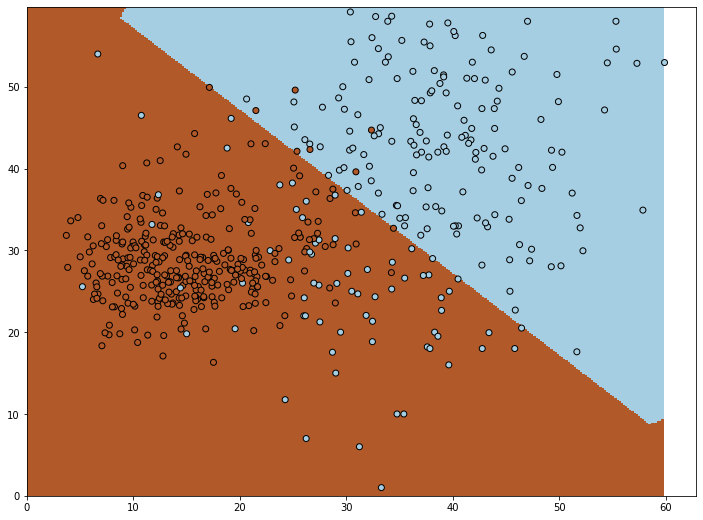

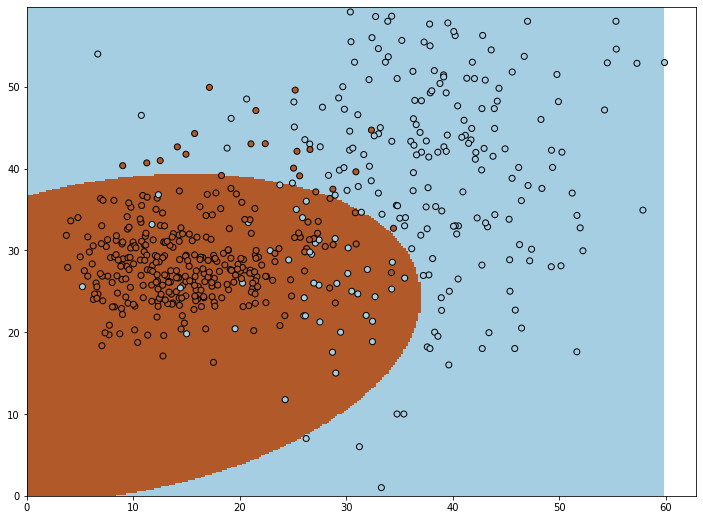

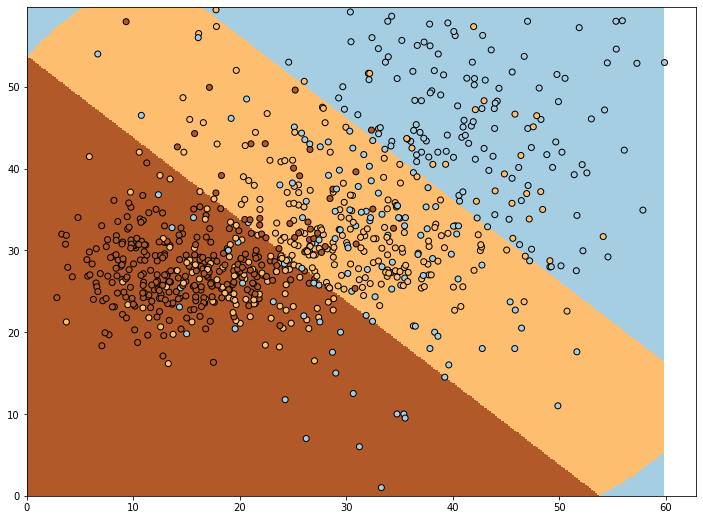

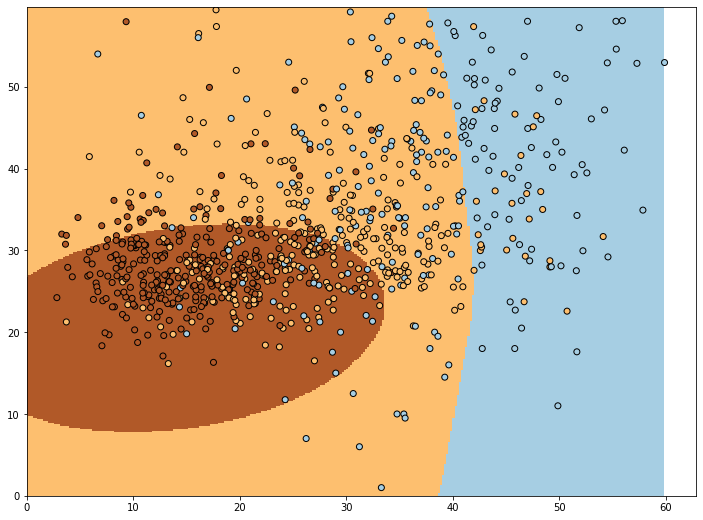

In [164]:
# Write the code for plotting here. 
def plot_class(X_train, Y_train, classifier):
  x_min, x_max = 0 , 60
  y_min, y_max = 0, 60
  h = 0.2  # step size in the mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Xsamples = np.c_[xx.ravel(), yy.ravel()]
  if (classifier==0):
    Z = Lin_clsf_1a(X_train, Y_train, Xsamples)
  elif (classifier==1):
    Z = Bayes_clsf_1b(X_train, Y_train, Xsamples)
  elif (classifier==2):
    Z = Lin_clsf_2a(X_train, Y_train, Xsamples)
  else:
    Z = Bayes_clsf_2b(X_train, Y_train, Xsamples)
  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure(figsize= (12, 9))
  plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
  #
  ix_plot0 = np.where((X_train[:, 0] <= 60))
  ix_plot1 = np.where((X_train[:, 1] <= 60))
  ix_plot = np.intersect1d(ix_plot0, ix_plot1)
  X_plot = X_train[ix_plot, :]
  plt.scatter(X_plot[:, 0], X_plot[:, 1], c=Y_train[ix_plot], edgecolors='k', cmap=plt.cm.Paired)

plot_class(X_train_bin, Y_train_bin, 0)
plot_class(X_train_bin, Y_train_bin, 1)
plot_class(X_train, Y_train, 2)
plot_class(X_train, Y_train, 3)

**Observations:**

In the next Textwrite cell, summarise (use the plots of the data and the assumptions in the problem to explain) your observations regarding the four learnt classifiers, and also give the error rate of the four classifiers as a 2x2 table.

## Remarks on Linear and Bayesian Classifiers

- As expected, the decision boundary for the linear predictors is linear while the decision boundary for bayesian predictors is quadratic

- For binary classifiers, the Bayesian classifier performs better than the Linear classifier. This is expected because the former estimates the empirical covariance matrix while the latter assumes that the data points are uncorrelated given the class

- The performance of the multiclass classifier could be improved by varying the loss matrix, since it is a hyperparameter

- From the plot of the decision boundaries for the multiclass classifiers, linear boundaries seem to be more apt than quadratic boundaries. This is consistent with the trend in error rates as well

- Error Rates

  * Binary Linear Classifier: 0.7942

  * Binary Bayesian Classifier: 0.8708

  * Multiclass Linear Classifier: 0.6257

  * Multiclass Bayesian Classifier: 0.5566